# Kalman Filter Parameter Exploration for CubeSat Altitude Estimation

This notebook demonstrates the impact of different Kalman filter parameters (P, Q, R, initial state) on the estimation of a CubeSat's altitude in Low Earth Orbit (LEO) using simulated noisy measurements. The goal is to understand how these parameters affect the filter's performance and to illustrate best practices for tuning them in a GNC (Guidance, Navigation, Control) context.

## 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

## 2. Simulate a realistic LEO altitude profile with perturbations

We simulate a CubeSat in a 400 km LEO orbit with a small sinusoidal perturbation to mimic orbital variations.

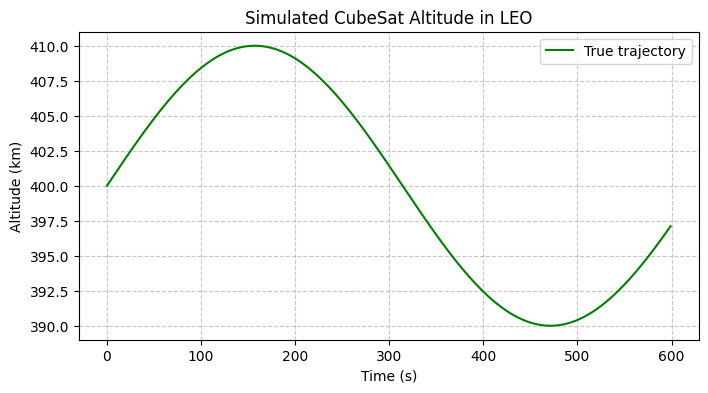

In [2]:
# Simulation parameters
altitude = 400  # km
duration = 600  # seconds (10 min)
dt = 1.0

time_steps = np.arange(0, duration, dt)
true_positions = altitude + 10 * np.sin(0.01 * time_steps)  # Realistic oscillation

plt.figure(figsize=(8, 4))
plt.plot(time_steps, true_positions, 'g-', label='True trajectory')
plt.title('Simulated CubeSat Altitude in LEO')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 3. Add Gaussian noise to the measurements

We add Gaussian noise (σ = 5 km) to the simulated altitude measurements to mimic sensor errors.

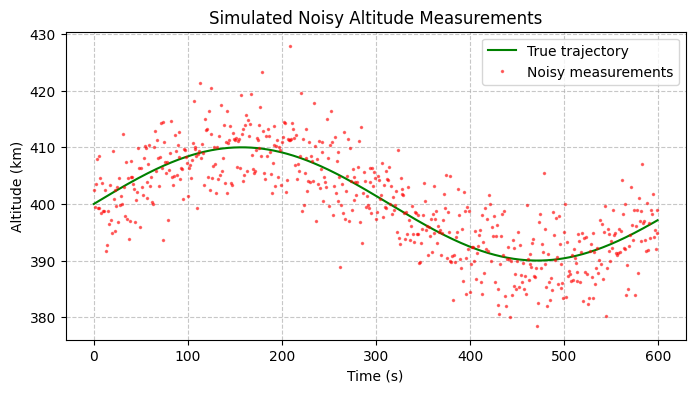

In [3]:
np.random.seed(42)  # For reproducibility
sensor_noise_std = 5  # km
noisy_measurements = true_positions + np.random.normal(0, sensor_noise_std, len(true_positions))

plt.figure(figsize=(8, 4))
plt.plot(time_steps, true_positions, 'g-', label='True trajectory')
plt.plot(time_steps, noisy_measurements, 'r.', markersize=3, alpha=0.5, label='Noisy measurements')
plt.title('Simulated Noisy Altitude Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4. Configure and run the Kalman filter for different scenarios

We define several scenarios by varying the Kalman filter parameters (P, Q, R, initial state). For each scenario, we run the filter and store the estimated altitude.

In [6]:
class SatelliteTracker:
    """
    Simple 1D Kalman Filter for altitude estimation.
    """
    def __init__(self, initial_pos=400.0, initial_vel=0.03, dt=1.0, P=None, Q=None, R=None):
        self.kf = KalmanFilter(dim_x=2, dim_z=1)
        self.kf.x = np.array([initial_pos, initial_vel])
        self.kf.F = np.array([[1., dt], [0., 1.]])
        self.kf.H = np.array([[1., 0.]])
        self.kf.P = P if P is not None else np.diag([10.0, 0.1])
        self.kf.Q = Q if Q is not None else np.array([[0.1, 0], [0, 0.01]])
        self.kf.R = R if R is not None else 25.0
    def update(self, measurement):
        self.kf.predict()
        self.kf.update(np.array([measurement]))
        self.kf.x[0] = max(150, self.kf.x[0])
        return self.kf.x[0]

# Compute a realistic initial velocity from the simulated trajectory
realistic_velocity = (np.max(true_positions) - np.min(true_positions)) / duration

scenarios = [
    {
        'name': 'Smooth (high R, low Q)',
        'color': 'b',
        'params': dict(P=np.diag([10.0, 0.1]), R=100.0, Q=np.array([[0.01, 0], [0, 0.001]]), initial_pos=true_positions[0], initial_vel=realistic_velocity)
    },
    {
        'name': 'Reactive (low R, high Q)',
        'color': 'm',
        'params': dict(P=np.diag([10.0, 0.1]), R=1.0, Q=np.array([[1.0, 0], [0, 0.1]]), initial_pos=true_positions[0], initial_vel=realistic_velocity)
    },
    {
        'name': 'Bad init (wrong pos, high P)',
        'color': 'c',
        'params': dict(P=np.diag([1000.0, 10.0]), R=25.0, Q=np.array([[0.1, 0], [0, 0.01]]), initial_pos=350.0, initial_vel=realistic_velocity)
    },
    {
        'name': 'Rigid model (very low Q)',
        'color': 'orange',
        'params': dict(P=np.diag([10.0, 0.1]), R=25.0, Q=np.array([[0.0001, 0], [0, 0.0001]]), initial_pos=true_positions[0], initial_vel=realistic_velocity)
    },
    {
        'name': 'Noisy sensor (very high R)',
        'color': 'k',
        'params': dict(P=np.diag([10.0, 0.1]), R=400.0, Q=np.array([[0.1, 0], [0, 0.01]]), initial_pos=true_positions[0], initial_vel=realistic_velocity)
    },
    {
        'name': 'Precise sensor (very low R)',
        'color': 'g',
        'params': dict(P=np.diag([10.0, 0.1]), R=1.0, Q=np.array([[0.1, 0], [0, 0.01]]), initial_pos=true_positions[0], initial_vel=realistic_velocity)
    }
]

results = {}
for scenario in scenarios:
    tracker = SatelliteTracker(**scenario['params'], dt=dt)
    est = []
    for z in noisy_measurements:
        est.append(tracker.update(z))
    results[scenario['name']] = (scenario['color'], est)

## 5. Visualize the results for each scenario

We plot the true trajectory, noisy measurements, and the Kalman filter estimations for all scenarios on a single figure for comparison.

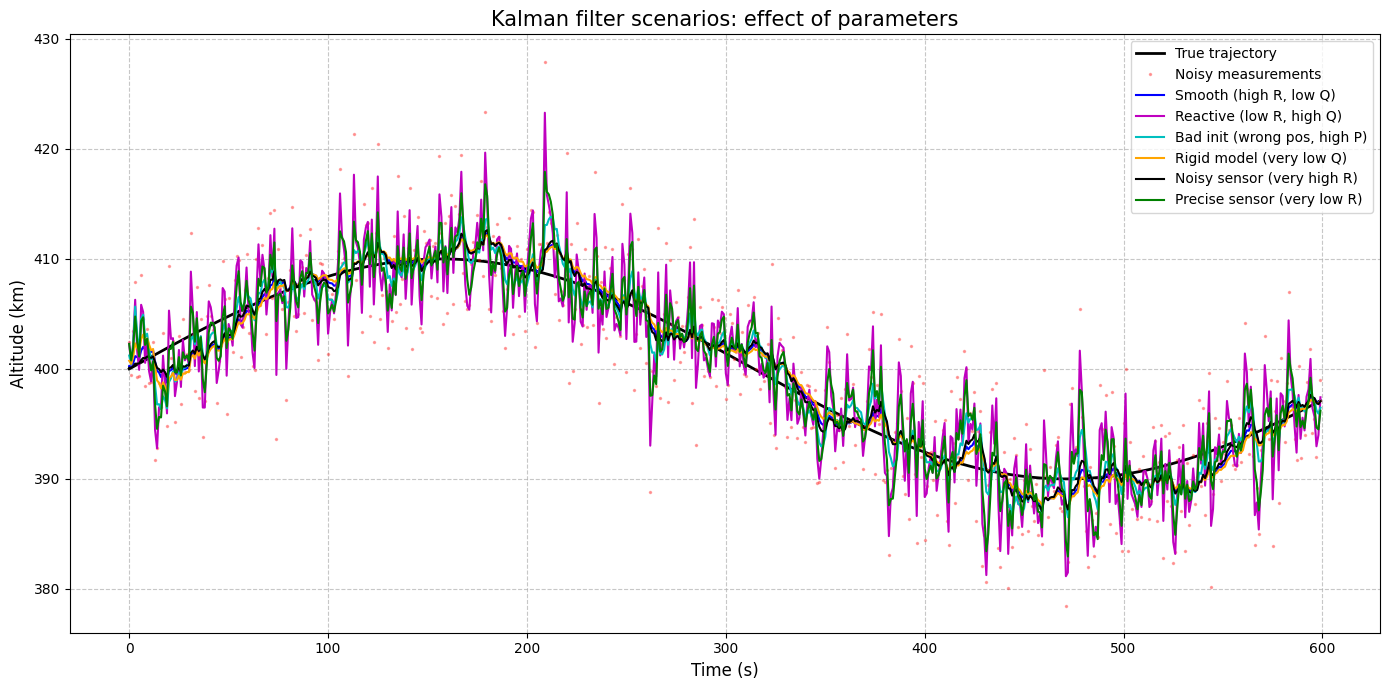

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(time_steps, true_positions, 'k-', linewidth=2, label='True trajectory')
plt.plot(time_steps, noisy_measurements, 'r.', markersize=3, alpha=0.3, label='Noisy measurements')

for name, (color, est) in results.items():
    plt.plot(time_steps, est, color=color, label=name)

plt.title('Kalman filter scenarios: effect of parameters', fontsize=15)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Altitude (km)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Key observations and analysis

- **High R (measurement noise):** The filter produces a smoother but less reactive estimation, ignoring much of the measurement noise.
- **High Q (process noise):** The filter is more reactive and follows the measurements closely, but the estimation is noisier.
- **High P (initial uncertainty):** The filter converges quickly even if the initial state is far from the truth.
- **Low Q:** The estimation is rigid and slow to adapt to real changes in the trajectory.
- **High R:** The filter ignores noisy measurements and adapts slowly.
- **Low R:** The filter follows the measurements closely, resulting in a noisier estimation.

**Conclusion:**

The Kalman filter's performance is highly sensitive to the choice of Q, R, and P. A realistic initial velocity is crucial to avoid large initial jumps. The best trade-off depends on the sensor quality and the expected dynamics. This exploration provides a solid foundation for further work in GNC, such as extending to 2D/3D orbits or integrating with a controller for debris avoidance.